In [1]:
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate

!pip install datasets
!pip install ml_things

from sklearn.metrics import accuracy_score
import numpy as np

import torch

import pandas as pd
from tqdm import tqdm

from transformers import (set_seed,
                          GPTJConfig, 
                          AutoTokenizer, 
                          GPTJForCausalLM,
                          )
from collections import OrderedDict
from ml_things import plot_dict

# for graphing
import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-cktyqkrt
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-cktyqkrt
  Resolved https://github.com/huggingface/transformers to commit f48d3314e42bf54accc9dd8fd8dc1bf4197b34c6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.3 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.28.0.dev0-py3-none-any.whl size=6789867 sha256=87c7b9a112b9f4a635bf38b008f42d9bcd1f1f40cae123ebad72825df67546b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-cy_zkntb/wheels/14/a0/7b/8f6b25ba4110aa215fcb8d6aedd6cd4f9b9b6619190

In [2]:
# klue/ynat 데이터 불러오기
from datasets import load_dataset

dataset = load_dataset("klue", "ynat")

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/ynat/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# argment setting
model_checkpoint = "kakaobrain/kogpt"
max_length = 64

In [5]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')
    
# klue/ynat 라벨 설정
labels_ids = {0:'IT과학', 1:'경제', 2:'사회', 3:'생활문화', 4:'세계', 5:'스포츠', 6:'정치'}

# 라벨 크기 설정.
n_labels = len(labels_ids)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [6]:
# Get model's tokenizer.
tokenizer = AutoTokenizer.from_pretrained(
  model_checkpoint, revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
  bos_token='[BOS]', eos_token='[EOS]', unk_token='[UNK]', pad_token='[PAD]', mask_token='[MASK]'
)

In [7]:
!pip install bitsandbytes

from torch import nn
from bitsandbytes.functional import quantize_blockwise, dequantize_blockwise
import torch.nn.functional as F
from torch import nn
from torch.cuda.amp import custom_fwd, custom_bwd
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 21.5 MB/s eta 0:00:00

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--listen_host=172.28.0.12 --target_host=172.28.0.12 --tunnel_background_save_url=https'), PosixPath('//colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-a100-s-1tsxhnpvut0dc --tunnel_background_save_delay=10s --tunnel_periodic_background_save_frequency=30m0s --enable_output_coalescing=true --output_coalescing_require

In [8]:
from typing import Tuple
from torch.cuda.amp import custom_fwd, custom_bwd


class DequantizeAndLinear(torch.autograd.Function):
    
    @staticmethod
    @custom_fwd
    def forward(ctx, input: torch.Tensor, weights_quantized: torch.ByteTensor,
                absmax: torch.FloatTensor, code: torch.FloatTensor, bias: torch.FloatTensor):
        
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        ctx.save_for_backward(input, weights_quantized, absmax, code)
        ctx._has_bias = bias is not None
        return F.linear(input, weights_deq, bias)
    
    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output: torch.Tensor):
        assert not ctx.needs_input_grad[1] and not ctx.needs_input_grad[2] and not ctx.needs_input_grad[3]
        input, weights_quantized, absmax, code = ctx.saved_tensors
        # grad_output: [*batch, out_features]
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        grad_input = grad_output @ weights_deq
        grad_bias = grad_output.flatten(0, -2).sum(dim=0) if ctx._has_bias else None
        return grad_input, None, None, None, grad_bias


class BNBLinearWithAdapter(nn.Module):
    def __init__(self, weight, absmax, code,  bias=None, adapter_dim=0):
        assert isinstance(bias, nn.Parameter) or bias is None
        super().__init__()
        self.out_features, self.in_features = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.bias = bias
        
        if adapter_dim > 0:
            self.adapter = nn.Sequential(
                nn.Linear(self.in_features, adapter_dim, bias=False),
                nn.Linear(adapter_dim, self.out_features, bias=False),
            )
            
            nn.init.zeros_(self.adapter[1].weight)
        else:
            self.adapter = None
        
    def forward(self, input):
        out = DequantizeAndLinear.apply(input, self.weight, self.absmax, self.code, self.bias)
        
        if self.adapter:
            return self.adapter(input) + out
            
        return out
        
    
    @classmethod
    def from_linear(cls, linear: nn.Linear, **kwargs) -> "FrozenBNBLinear":
        weights_int8, state = quantize_blockise_lowmemory(linear.weight)
        return cls(weights_int8, *state, linear.bias, **kwargs)
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"


class BNBEmbeddingWithAdapter(nn.Module):
    def __init__(self, weight, absmax, code, adapter_dim=0):
        super().__init__()
        self.num_embeddings, self.embedding_dim = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        
        if adapter_dim > 0:
            self.adapter = nn.Sequential(
                nn.Embedding(self.num_embeddings, adapter_dim),
                nn.Linear(adapter_dim, self.embedding_dim, bias=False),
            )
            
            nn.init.zeros_(self.adapter[1].weight)
        else:
            self.adapter = None
        
    def forward(self, input, **kwargs):
        with torch.no_grad():
            # note: both quantuized weights and input indices are *not* differentiable
            weight_deq = dequantize_blockwise(self.weight, absmax=self.absmax, code=self.code)
            out = F.embedding(input, weight_deq, **kwargs)
        if self.adapter:
            return out + self.adapter(input, **kwargs)
        
        return out
    
    @classmethod
    def from_embedding(cls, embedding: nn.Embedding, **kwargs) -> "FrozenBNBEmbedding":
        weights_int8, state = quantize_blockise_lowmemory(embedding.weight)
        return cls(weights_int8, *state, **kwargs)
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.num_embeddings}, {self.embedding_dim})"

In [9]:
def quantize_blockise_lowmemory(matrix: torch.Tensor, chunk_size: int = 2 ** 20):
    assert chunk_size % 4096 == 0
    code = None
    chunks = []
    absmaxes = []
    flat_tensor = matrix.reshape(-1)
    for i in range((matrix.numel() - 1) // chunk_size + 1):
        input_chunk = flat_tensor[i * chunk_size: (i + 1) * chunk_size].clone()
        quantized_chunk, (absmax_chunk, code) = quantize_blockwise(input_chunk, code=code)
        chunks.append(quantized_chunk)
        absmaxes.append(absmax_chunk)
        
    matrix_i8 = torch.cat(chunks).reshape_as(matrix)
    absmax = torch.cat(absmaxes)
    return matrix_i8, (absmax, code)

In [10]:
def bnbfy_(model, adapter_dim: int = 0):
    for module in list(model.modules()):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                print(name, child)
                setattr(module, name, BNBLinearWithAdapter.from_linear(child, adapter_dim=adapter_dim))
                
            elif isinstance(child, nn.Embedding):
                print(name, child)
                setattr(module, name, BNBEmbeddingWithAdapter.from_embedding(child, adapter_dim=adapter_dim))

In [11]:
from accelerate import init_empty_weights
from transformers import AutoConfig, AutoModelForCausalLM

print('Loading model...')
model = GPTJForCausalLM.from_pretrained(model_checkpoint, revision='KoGPT6B-ryan1.5b-float16', torch_dtype='auto', low_cpu_mem_usage=True)
model.resize_token_embeddings(len(tokenizer))

Loading model...


Embedding(63998, 4096)

In [12]:
bnbfy_(model, adapter_dim=16)

lm_head Linear(in_features=4096, out_features=63998, bias=True)
wte Embedding(63998, 4096)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features

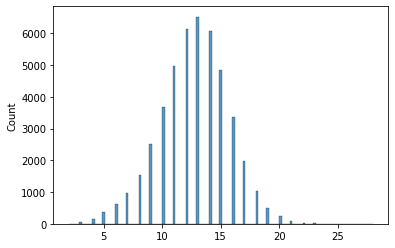

mean length : 12.67065107929419
min length : 2
max length : 28


In [13]:
# 훈련 데이터 시각화
tokenizer_len = [len(tokenizer(s)['input_ids']) for s in dataset['train']['title']]
sns.histplot(tokenizer_len)
plt.show()

print(f"mean length : {np.mean(tokenizer_len)}")
print(f"min length : {np.min(tokenizer_len)}")
print(f"max length : {np.max(tokenizer_len)}")

In [14]:
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The beginning of sequence token [BOS] token has the id 0
The end of sequence token [EOS] has the id 1
The padding token [PAD] has the id 3


In [15]:
# Dataset class
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
  def __init__(self, txt_list, label_list, tokenizer, max_length):
    # define variables
    self.input_ids = []
    self.attn_masks = []
    self.labels = []
    map_label = {0:'IT과학', 1:'경제', 2:'사회', 3:'생활문화', 4:'세계', 5:'스포츠', 6:'정치'}

    # iterate through the dataset
    for txt, label in zip(txt_list, label_list):
      
      # prepare the text
      prep_txt = f'[BOS]텍스트: {txt}\n주제: {map_label[label]}[EOS]'

      # tokenize
      encodings_dict = tokenizer(prep_txt, truncation=True, max_length=max_length, padding="max_length")

      # append to list
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
      self.labels.append(map_label[label])
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx], self.labels[idx]

In [16]:
def load_dataset(tokenizer):
  train_dataset = ClassificationDataset(dataset['train']['title'], dataset['train']['label'], tokenizer, max_length = max_length)
  valid_dataset = ClassificationDataset(dataset['validation']['title'], dataset['validation']['label'], tokenizer, max_length = max_length)

  return train_dataset, valid_dataset

In [17]:
## Load model and data

# seed
torch.manual_seed(42)
model.resize_token_embeddings(len(tokenizer))

BNBEmbeddingWithAdapter(63998, 4096)

In [18]:
def save_adapter(model, filepath):
  old_dict = model.state_dict()
  new_dict = OrderedDict()
  for key, val in old_dict.items():
    if 'adapter' in key:
      new_dict[key] = val
  
  torch.save(new_dict, filepath)

In [19]:
def load_adapter(model, filepath):
  new_dict = torch.load(filepath)
  old_dict = model.state_dict()

  for key, val in new_dict.items():
    old_dict[key] = val

  model.load_state_dict(old_dict)

In [36]:
PATH = "/content/drive/MyDrive/ynat_adapter.pth"
load_adapter(model, PATH)

In [21]:
model.cuda()

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): BNBEmbeddingWithAdapter(63998, 4096)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): BNBLinearWithAdapter(4096, 4096)
          (v_proj): BNBLinearWithAdapter(4096, 4096)
          (q_proj): BNBLinearWithAdapter(4096, 4096)
          (out_proj): BNBLinearWithAdapter(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): BNBLinearWithAdapter(4096, 16384)
          (fc_out): BNBLinearWithAdapter(16384, 4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropou

In [22]:
train_dataset, valid_dataset = load_dataset(tokenizer)

In [23]:
train_dataset[0]

(tensor([    0, 22179,   132,  7453, 18881,   479,   530,   841, 25685,  1471,
          2242,  1618, 63997, 10886,   132,  1905,  1870,     1,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 '생활문화')

In [30]:
def sample(n):
  data = {
      'title':dataset['validation']['title'],
      'label':dataset['validation']['label']
  }
  return pd.DataFrame(data).sample(n)

test = sample(100)
# test = {
#       'title':dataset['validation']['title'],
#       'label':dataset['validation']['label']
#   }

In [31]:
import re
## Test

# set the model to eval mode
model.eval()

# run model inference on all test data
original_label, predicted_label, original_text, predicted_text = [], [], [], []

map_label = {0:'IT과학', 1:'경제', 2:'사회', 3:'생활문화', 4:'세계', 5:'스포츠', 6:'정치'}

# iter over all test data
for text, label in tqdm(zip(test['title'], test['label'])):
  # create prompt (int compliance with the one used during training)
  prompt = f'[BOS]텍스트: {text}\n주제:'

  # generate tokens
  generated = tokenizer(f'{prompt}', return_tensors='pt').input_ids.cuda()

  # perform prediction
  sample_outputs = model.generate(generated, do_sample=False, top_k = 50, max_length = max_length, top_p = 0.90,
                                  temperature=0, num_return_sequences=0,
                                  pad_token_id=tokenizer.pad_token_id,
                                  eos_token_id=tokenizer.eos_token_id,
                                  bos_token_id=tokenizer.bos_token_id, 
                                  use_cache=True)
  
  # decode the predicted tokens into texts
  pred_text = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

  # extract the predicted label
  try:
    pred_label = re.findall('\n주제: (.*)', pred_text)[-1]
  except:
    pred_label = "None"

  # append results
  original_label.append(map_label[label])
  predicted_label.append(pred_label)
  original_text.append(text)
  predicted_text.append(pred_text)

# transform result into dataframe
df = pd.DataFrame({'original_text' : original_text,
                   'predicted_label' : predicted_label,
                   'original_label' : original_label,
                   'predicted_text' : predicted_text})

100it [00:24,  4.10it/s]


In [32]:
df

,original_text,predicted_label,original_label,predicted_text
0,코로나19·기생충 테마주까지…주가급등락에 시장경보 27%↑,경제,경제,텍스트: 코로나19·기생충 테마주까지…주가급등락에 시장경보 27%↑\n주제: 경제
1,급변사태시 北주민에 2개월치 90만t 긴급지원해야,정치,정치,텍스트: 급변사태시 北주민에 2개월치 90만t 긴급지원해야\n주제: 정치
2,롯데 임원인사 여진…최춘석 롯데슈퍼 대표 사표,경제,사회,텍스트: 롯데 임원인사 여진…최춘석 롯데슈퍼 대표 사표\n주제: 경제
3,진웅섭 금감원장 집단대출 규제 안 한다종합,경제,사회,텍스트: 진웅섭 금감원장 집단대출 규제 안 한다종합\n주제: 경제
4,북중러 접경 中 훈춘 올해 철도교역량 증가세 주춤,세계,세계,텍스트: 북중러 접경 中 훈춘 올해 철도교역량 증가세 주춤\n주제: 세계
...,...,...,...,...
95,미·이란 긴장 불똥 튄 이라크…또 새우등 터질까,세계,세계,텍스트: 미·이란 긴장 불똥 튄 이라크…또 새우등 터질까\n주제: 세계
96,서울 강남구 현대고 3학년생 확진…오늘 조기 하교,사회,사회,텍스트: 서울 강남구 현대고 3학년생 확진…오늘 조기 하교\n주제: 사회
97,행사장으로 이동하는 박영선 장관과 구현모 KT 대표,사회,사회,텍스트: 행사장으로 이동하는 박영선 장관과 구현모 KT 대표\n주제: 사회
98,아파트 경로당·놀이터 등 인근 주민과 공동이용 가능해진다,사회,사회,텍스트: 아파트 경로당·놀이터 등 인근 주민과 공동이용 가능해진다\n주제: 사회


In [33]:
from sklearn.metrics import f1_score
result = f1_score(df['original_label'], df['predicted_label'], average = 'macro')

In [34]:
# f1 score
result

0.8974030031043408

In [35]:
model.eval()
prompt = '텍스트: 넥센타이어 강호찬 대표이사 사장 신규 선임\n주제:'
with torch.no_grad():
  tokens = tokenizer.encode(prompt, return_tensors='pt').to(device='cuda', non_blocking=True)
  sample_outputs = model.generate(tokens, do_sample=False, top_k = 50, max_length = max_length, top_p = 0.90,
                                  temperature=0, num_return_sequences=0,
                                  pad_token_id=tokenizer.pad_token_id,
                                  eos_token_id=tokenizer.eos_token_id,
                                  bos_token_id=tokenizer.bos_token_id, 
                                  use_cache=True)
  generated = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

print(generated)

텍스트: 넥센타이어 강호찬 대표이사 사장 신규 선임
주제: 사회
